In [46]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import Image, display

In [2]:
# Download the images @ https://storage.googleapis.com/mlep-public/course_3/week2/images.zip

base_dir = './data/'

# Save paths for images of each class
dogs_dir = os.path.join(base_dir, 'images/dogs')
cats_dir = os.path.join(base_dir,'images/cats')
birds_dir = os.path.join(base_dir,'images/birds')

# Print number of images for each class
print(f"There are {len(os.listdir(dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(cats_dir))} images of cats")
print(f"There are {len(os.listdir(birds_dir))} images of birds\n\n")

There are 123 images of dogs
There are 123 images of cats
There are 116 images of birds




Sample cat image:


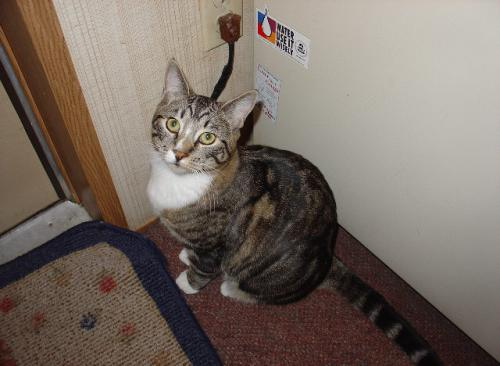


Sample dog image:


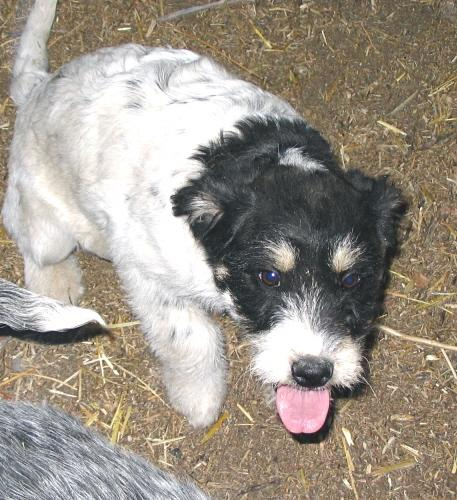


Sample bird image:


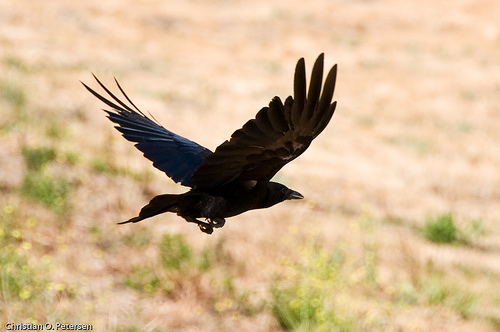

In [3]:
print("Sample cat image:")
display(Image(filename=f"{os.path.join(cats_dir, os.listdir(cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(dogs_dir, os.listdir(dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(birds_dir, os.listdir(birds_dir)[0])}"))

##### Load Pretrained Model

In [4]:
model = tf.keras.models.load_model('./model')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

#### Save your model

- To load our trained model into TensorFlow Serving we first need to save it in SavedModel format
- This will create a [protobuf](https://developers.google.com/protocol-buffers) file in a well-defined directory hierarchy, and will include a version number
- [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests
- Each version will be exported to a different sub-directory under the given path

- A saved model on disk includes the following files:
- `assets`: a directory including arbitrary files used by the TF graph.
- `variables`: a directory containing information about the training checkpoints of the model.
- `saved_model.pb`: the protobuf file that represents the actual TF program.

In [30]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print(f'export_path = {export_path}\n')


# Save the model
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = C:\Users\clare\AppData\Local\Temp\1



INFO:tensorflow:Assets written to: C:\Users\clare\AppData\Local\Temp\1\assets


INFO:tensorflow:Assets written to: C:\Users\clare\AppData\Local\Temp\1\assets


In [8]:
import time 
ts = int(time.time())

In [9]:
file_path = f"./img_classifier/{ts}/"
model.save(filepath=file_path, save_format='tf')

INFO:tensorflow:Assets written to: ./img_classifier/1716865059/assets


INFO:tensorflow:Assets written to: ./img_classifier/1716865059/assets


#### Examine the saved model

- We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](https://www.tensorflow.org/tfx/serving/signature_defs) (the methods you can call) in our SavedModel.

In [31]:
!saved_model_cli show --dir {export_path} --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 150, 150, 3)
      name: serving_default_conv2d_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


#### Get data

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to the directory with the test images
val_gen_no_shuffle = test_datagen.flow_from_directory(
    './data/images',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

# Print the label that is assigned to each class
print(f"labels for each class in the test generator are: {val_gen_no_shuffle.class_indices}")

Found 362 images belonging to 3 classes.
labels for each class in the test generator are: {'birds': 0, 'cats': 1, 'dogs': 2}


In [33]:
# Get a batch of 32 images along with their true label
data_imgs, labels = next(val_gen_no_shuffle)

# Check shapes
print(f"data_imgs has shape: {data_imgs.shape}")
print(f"labels has shape: {labels.shape}")

data_imgs has shape: (32, 150, 150, 3)
labels has shape: (32,)


##### Run the below in a terminal
- docker run -p 8501:8501 --name tfserving_classifier --mount type=bind,source={model_dir},target=/models/img_classifier -e MODEL_NAME=img_classifier -t tensorflow/serving

#### Test

In [35]:
from tensorflow.keras.preprocessing.image import array_to_img

# Returns string representation of each class
def get_class(index):
  if index == 0:
    return "bird"
  elif index == 1:
    return "cat"
  elif index == 2:
    return "dog"
  return None


# Plots a numpy array representing an image
def plot_array(array, label, pred=None):
  array = np.squeeze(array)
  img = array_to_img(array)
  display(img)
  if pred is None:
    print(f"Image shows a {get_class(label)}.\n")
  else:
    print(f"Image shows a {get_class(label)}. Model predicted it was {get_class(pred)}.\n")


In [39]:
import json

# Convert numpy array to list
data_imgs_list = data_imgs.tolist()

# Create JSON to use in the request
data = json.dumps({"instances": data_imgs_list})

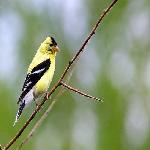

Image shows a bird.



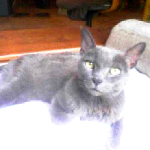

Image shows a cat.



In [41]:
# Plot the first 5 images in the batch
for i in range(2):
  plot_array(data_imgs[i], labels[i])

In [42]:
import requests

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/img_classifier:predict', data=data, headers=headers)

predictions = json.loads(json_response.text)['predictions']
print(f"predictions has shape: {np.asarray(predictions).shape}")

predictions has shape: (32, 3)


In [44]:
preds = np.argmax(predictions, axis=1)
print(f"preds has shape: {preds.shape}")
print(preds)

preds has shape: (32,)
[0 1 2 2 0 2 0 2 2 2 2 1 0 0 2 0 1 2 1 2 0 2 2 0 2 0 0 2 2 0 1 2]


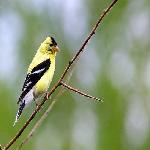

Image shows a bird. Model predicted it was bird.



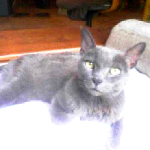

Image shows a cat. Model predicted it was cat.



In [45]:
for i in range(2):
  plot_array(data_imgs[i], labels[i], preds[i])